# 📊**Twitter NER**

## 📝 **Metadata**

**Notebook Title:** NLP: Twitter NER   
**Author:** Vishnu Vineeth P M

**Date Created:** May 2025   
**Tools Used:** Python, Pandas, Scikit-learn, Tensorflow  
**Objective:** To train models that can accurately perform Named Entity Recognition (NER) on tweet data.

## 📝**Introduction**

Twitter is a microblogging and social networking service on which users post and interact with messages known as "tweets". Every second, on average, around 6,000 tweets are tweeted on Twitter, corresponding to over 350,000 tweets sent per minute, 500 million tweets per day.

Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.


Named Entity Recognition (NER) is an important subtask of information extraction that seeks to locate and recognise named entities.


## **Data description**

Dataset is annotated with 10 fine-grained NER categories: person, geo-location, company, facility, product,music artist, movie, sports team, tv show and other. Dataset was extracted from tweets and is structured in CoNLL format., in English language. Containing in Text file format.

The CoNLL format is a text file with one word per line with sentences separated by an empty line. The first word in a line should be the word and the last word should be the label.

**Consider the two sentences below;**

Harry Potter was a student living in london

Albus Dumbledore went to the Disney World

These two sentences can be prepared in a CoNLL formatted text file as follows.

1. Harry B-PER

2. Potter I-PER

3. was O

4. a O

5. student O

6. Living O

7. in O

8. London B-geo-loc


9. Albus B-PER

10. Dumbledore I-PER

11. went O

12. to O

13. the O

14. Disney B-facility

15. World I-facility

## **Importing necessary libraries**

In [1]:
!pip install gensim
#!pip install --upgrade pip setuptools wheel
!pip install transformers datasets seqeval -q
!pip install evaluate

Defaulting to user installation because normal site-packages is not writeable
  Using cached FuzzyTM-2.0.9-py3-none-any.whl.metadata (7.9 kB)
  Using cached pyFUME-0.3.4-py3-none-any.whl.metadata (9.7 kB)
  Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
  Using cached simpful-2.12.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached fst-pso-1.8.1.tar.gz (18 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [14 lines of output]
  ERROR: Can not execute `setup.py` since setuptools failed to import in the build environment with exception:
  Traceback (most recent call last):
    File "<pip-setuptools-caller>", line 14, in <module>
    File "C:\Users\Vishnu\AppData\Roaming\Python\Python311\site-packages\setuptools\__init__.py", line 26, in <module>
      from .dist import Distribution
    File "C:\Users\Vishnu\AppData\Roaming\Python\Python311\site-packages\setuptools\dist.py", line 20, in <module>
      from . import (
    File "C:\Users\Vishnu\AppData\Roaming\Python\Python311\site-packages\setuptools\_entry_points.py", line 6, in <module>
      from jaraco.text import yield_lines
    File "C:\Users\Vishnu\AppData\Roaming\Python\Python311\site-packages\setuptools\_vendor\jaraco\text\__init__.py", line 12, in <module>
      from jaraco.context import ExceptionTrap
    File "C:\Use

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow_addons.layers import CRF
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

from gensim.models import Word2Vec


import warnings
warnings.filterwarnings("ignore")


C:\Users\Vishnu\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import tensorflow as tf

# Check if TensorFlow is built with CUDA support
if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA support.")
else:
    print("TensorFlow is not built with CUDA support.")

# Check if a GPU is available and visible
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available.")
else:
    print("CUDA is not available.")


TensorFlow is not built with CUDA support.
CUDA is not available.


In [4]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
 BATCH_SIZE = 512 # Number of examples used in each iteration
 EPOCHS = 5 # Number of passes through entire dataset
 MAX_LEN = 75 # Max length of review (in words)
 EMBEDDING = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
 BATCH_SIZE = 32
 EPOCHS = 5
 MAX_LEN = 75
 EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Data Preprocessing

In [5]:
#let us see the dataset
def read_conll(file_path):
    
    sentences = []    #list to store all the sentences
    sentence = []     #list to store tokens(word, tag) for current sentence
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()              #remove any white spaces
            if line:                            #if line not empty
                token, tag = line.split('\t')   #split the line into token and tags
                sentence.append((token, tag))   #add token and tag into sentence
            else:                               #if the line is empty (end of sentence)
                if sentence:                  
                    sentences.append(sentence)  #save the complete sentence
                    sentence = []               #reset for next sentence
    return sentences

In [6]:
data = read_conll("wnut 16.txt.conll")
data[0]


[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [7]:
data[2]

[("'", 'O'),
 ('Breaking', 'B-movie'),
 ('Dawn', 'I-movie'),
 ("'", 'O'),
 ('Returns', 'O'),
 ('to', 'O'),
 ('Vancouver', 'B-geo-loc'),
 ('on', 'O'),
 ('January', 'O'),
 ('11th', 'O'),
 ('http://bit.ly/dbDMs8', 'O')]

In [8]:
#length of the data
len(data)

2393

### Data Transformation for NER

In [9]:
#converting to dataframe
df = pd.DataFrame([(token, tag) for value in data for token, tag in value], columns = ["Token", "Tag"])
df.head()

,Token,Tag
0,@SammieLynnsMom,O
1,@tg10781,O
2,they,O
3,will,O
4,be,O


## Exploratory Data Analysis

In [10]:
df.shape

(46462, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46462 entries, 0 to 46461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Token   46462 non-null  object
 1   Tag     46462 non-null  object
dtypes: object(2)
memory usage: 726.1+ KB


In [12]:
#number of sentences
print(f"There are {len(data)} sentences")

There are 2393 sentences


In [13]:
#number of tags
print(f"There are {df['Tag'].nunique()} labels in the dataset")

There are 21 labels in the dataset


In [14]:
#frequency of the labels
df["Tag"].value_counts()

Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64

In [15]:
#sentence length
sentence_length = [len(s) for s in data]
print(sorted(sentence_length, reverse = True)[:10])
print(sorted(sentence_length)[:10])

[39, 39, 38, 37, 37, 36, 36, 36, 35, 35]
[1, 2, 2, 2, 2, 3, 3, 3, 3, 3]


The sentence lengths varies from 1 to 39

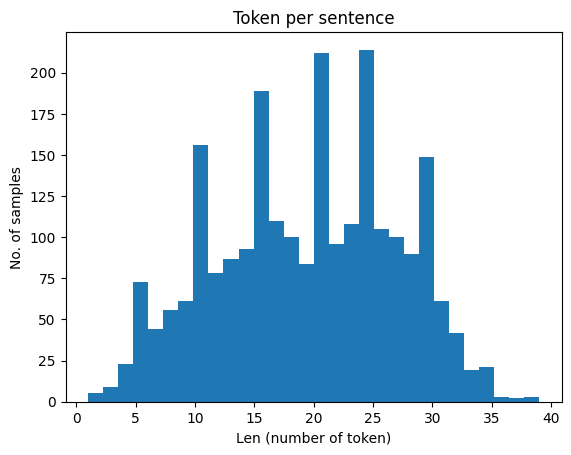

In [16]:
#plotting the sentence length
plt.hist(sentence_length, bins = 30)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('No. of samples')
plt.show()

**Insights**
- Most sentences fall in the range of 10 to 30 long tokens
- Peaks around 20 to 25
- Very few sentences are extremely short (<5) or very long (>35):
  - We can assume that extremely short or long sentences are rare and can be called as outliers.


### Handling sparse data

In [17]:
#to get the entity tag
df["Entity"] = df["Tag"].apply(lambda x: x.split("-")[-1] if len(x.split("-")) > 1 else "")
df.head(10)

,Token,Tag,Entity
0,@SammieLynnsMom,O,
1,@tg10781,O,
2,they,O,
3,will,O,
4,be,O,
5,all,O,
6,done,O,
7,by,O,
8,Sunday,O,
9,trust,O,


In [18]:
df.sample(3)

,Token,Tag,Entity
22613,album,O,
27944,",",O,
45352,would,O,


In [19]:
df["Entity"].value_counts()

Entity
               44000
person           664
other            545
loc              325
facility         209
company          207
product          177
musicartist      116
movie             80
sportsteam        74
tvshow            65
Name: count, dtype: int64

There is an imbalance in the entity values. So we can do resambling.

In [20]:
lowcount_labels = df["Entity"].value_counts()[3:].reset_index()["Entity"].tolist()

In [21]:
lowcount_labels

['loc',
 'facility',
 'company',
 'product',
 'musicartist',
 'movie',
 'sportsteam',
 'tvshow']

In [22]:
#let us see the data
for items in data[:3] :
    print(items)

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]
[('Made', 'O'), ('it', 'O'), ('back', 'O'), ('home', 'O'), ('to', 'O'), ('GA', 'B-geo-loc'), ('.', 'O'), ('It', 'O'), ('sucks', 'O'), ('not', 'O'), ('to', 'O'), ('be', 'O'), ('at', 'O'), ('Disney', 'B-facility'), ('world', 'I-facility'), (',', 'O'), ('but', 'O'), ('its', 'O'), ('good', 'O'), ('to', 'O'), ('be', 'O'), ('home', 'O'), ('.', 'O'), ('Time', 'O'), ('to', 'O'), ('start', 'O'), ('planning', 'O'), ('the', 'O'), ('next', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility'), ('trip', 'O'), ('.', 'O')]
[("'", 'O'), ('Breaking', 'B-movie'), ('Dawn', 'I-movie'), ("'", 'O'), ('Returns', 'O'), ('to', 'O'), ('Vancouver', 'B-geo-loc'), ('on', 'O'), ('January', 'O'), ('11th', 'O'), ('http://bit.ly/dbDMs8', 'O')]


In [23]:
#doing the oversampling on the lowcount labels
oversampling = {}
for label in lowcount_labels :
    oversampling[label] = []

for sentence in data :
    for word, label in sentence :
        if label.split("-")[-1] in lowcount_labels :
            oversampling[label.split("-")[-1]].append(sentence)
            break

In [24]:
for key, value in oversampling.items() :
    print(key, len(value))

loc 174
facility 77
company 135
product 65
musicartist 35
movie 24
sportsteam 37
tvshow 29


In [25]:
len(data)

2393

In [26]:
#doing the oversampling
oversampled_data = data + random.choices(oversampling["loc"], k = 200)

oversampled_data += random.choices(oversampling["facility"], k = 300)
oversampled_data += random.choices(oversampling["company"], k=300)
oversampled_data += random.choices(oversampling["product"], k=400)
oversampled_data += random.choices(oversampling["musicartist"], k=400)
oversampled_data += random.choices(oversampling["movie"], k=500)
oversampled_data += random.choices(oversampling["sportsteam"], k=500)
oversampled_data += random.choices(oversampling["tvshow"], k=500)

**What does the above code do?** : 

- random.choices() returns a list of 200 random elements with replacement from oversampling["loc"].

- That means some elements may appear more than once.

In [27]:
len(oversampled_data)

5493

## Tokenization and Encoding 

**We will do :**
1. Tokenization
2. Padding
3. Encoding

In [28]:
df["Token"].value_counts()

Token
.                  1524
,                   914
the                 876
to                  824
I                   762
                   ... 
ellwood               1
enuf                  1
blond                 1
adolf                 1
@PersonalSelena       1
Name: count, Length: 10585, dtype: int64

In [29]:
#number of unique words in the dataset
words = list(set(df["Token"].values))

print("Total number of unique words in the dataset is", len(words))

Total number of unique words in the dataset is 10585


In [30]:
#number of unique tags in the dataset
tags = list(set(df["Tag"].values))

print("Total number of unique labels in the dataset is", len(tags))

Total number of unique labels in the dataset is 21


In [31]:
tags

['I-product',
 'B-sportsteam',
 'I-other',
 'I-facility',
 'I-musicartist',
 'I-sportsteam',
 'I-company',
 'I-tvshow',
 'I-person',
 'B-movie',
 'O',
 'B-company',
 'B-musicartist',
 'I-movie',
 'B-person',
 'B-tvshow',
 'B-geo-loc',
 'B-product',
 'I-geo-loc',
 'B-other',
 'B-facility']

### Encoding

- We will create a dictionary called **word2idx** that assigns each word a unique integer.
- Similarly creates a dictionary **tag2idx** which maps each tag (like B-movie, I-movie, O, etc.) to a unique index.

In [32]:
word2idx = {w:i+2 for i,w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
tag2idx = {t:i+2 for i,t in enumerate(tags)}
tag2idx["PAD"] = 0
tag2idx["UNK"] = 1

i+2 starts indexing from 2 so that 0 and 1 can be reserved.

- PAD = 0 → For padding sequences to same length.

- UNK = 1 → For unknown words not in vocabulary.

In [33]:
#for example let us see the words "Breaking" and the label "B-movie"
print("The word Breaking has the index", word2idx["Breaking"])
print("The label B-movie has the index", tag2idx["B-movie"])

The word Breaking has the index 4691
The label B-movie has the index 11


In [34]:
tag2idx

{'I-product': 2,
 'B-sportsteam': 3,
 'I-other': 4,
 'I-facility': 5,
 'I-musicartist': 6,
 'I-sportsteam': 7,
 'I-company': 8,
 'I-tvshow': 9,
 'I-person': 10,
 'B-movie': 11,
 'O': 12,
 'B-company': 13,
 'B-musicartist': 14,
 'I-movie': 15,
 'B-person': 16,
 'B-tvshow': 17,
 'B-geo-loc': 18,
 'B-product': 19,
 'I-geo-loc': 20,
 'B-other': 21,
 'B-facility': 22,
 'PAD': 0,
 'UNK': 1}

### Padding

In [35]:
oversampled_data[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [36]:
X = []

for sentence in oversampled_data:
    word_indices = []
    for ele in sentence:
        word = ele[0]  # take the word from the (word, tag) tuple
        word_index = word2idx.get(word, word2idx["UNK"])  # use UNK if word not found
        word_indices.append(word_index)
    X.append(word_indices)


# pad the sequences, to have same length
X = pad_sequences(
 maxlen = MAX_LEN,
 sequences = X,
 padding = "post",
 value = word2idx["PAD"]
)
print('Raw Sample:\n ', ' '.join([w[0] for w in oversampled_data[0]]))
print('\n ' )
print('After processing, sample:\n', X[0])

Raw Sample:
  @SammieLynnsMom @tg10781 they will be all done by Sunday trust me *wink*

 
After processing, sample:
 [ 2302  9444  5186  2101  2825  1782  6108  8463   215  8025  8757 10137
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


In [37]:
X

array([[ 2302,  9444,  5186, ...,     0,     0,     0],
       [ 3845,  7517,   915, ...,     0,     0,     0],
       [ 6667,  4691,  2622, ...,     0,     0,     0],
       ...,
       [10384,  6597,  2279, ...,     0,     0,     0],
       [10300,  4432,  3572, ...,     0,     0,     0],
       [ 4021,  9476,  9923, ...,     0,     0,     0]])

In [38]:
len(X)

5493

In [39]:
# Convert my Tag/Label to tag_index
y = []

for sentence in oversampled_data:
    tag_indices = []
    for ele in sentence:
        tag = ele[1]  # take the tag from the (word, tag) tuple
        tag_index = tag2idx.get(tag, tag2idx["UNK"])  # use UNK if tag not found
        tag_indices.append(tag_index)
    y.append(tag_indices)
    
# Padding each label to have same length
y = pad_sequences(
 maxlen = MAX_LEN,
 sequences = y,
 padding = "post",
 value = tag2idx["PAD"]
)
print('Raw Label:\n ', ' '.join([w[1] for w in oversampled_data[0]]))
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Label:
  O O O O O O O O O O O O

 
After processing, labels:
 [12 12 12 12 12 12 12 12 12 12 12 12  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [40]:
y

array([[12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       [12, 11, 15, ...,  0,  0,  0],
       ...,
       [12, 12, 12, ...,  0,  0,  0],
       [21, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0]])

In [41]:
len(y)

5493

In [42]:
#one hot encoding for y
y = [to_categorical(i, num_classes = 23) for i in y]   #ntags = 22 + 1 (PAD) => num_classes = 23

#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [43]:
print(y_train.shape)
print(y_test.shape)

(4943, 75, 23)
(550, 75, 23)


In [44]:
len(X_train), len(X_test)

(4943, 550)

In [45]:
len(y_train), len(y_test)

(4943, 550)

In [46]:
X_train[0]

array([ 7599,  2924,  6889,  1643,  3404,  5911,  7184,  1665,  3973,
        8815,  4040,  9917,  4565,  4843,  3739,  4565,  5254,  9047,
        7569,  5916,   741,  6636,  5468,  9476,  9610, 10042,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [47]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
y_test

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

## Model Building

### **Training LSTM + CRF Models with Embeddings**

In [49]:
def build_model(max_len=75, input_dim=len(words)+2, embedding_dim=200): # 10585 vocab size
    # Model definition
    input_layer = Input(shape=(max_len,), name='input_layer')
    
    # Embedding layer
    embeddings = Embedding(
        input_dim=input_dim,
        output_dim=embedding_dim,
        input_length=max_len,
        mask_zero=True
    )(input_layer)
    
    # BiLSTM layers
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(lstm_output)
    
    # Dense layer
    dense_output = TimeDistributed(Dense(23, activation="relu"))(lstm_output)
    
    # CRF layer
    crf = CRF(23, name='crf') # 21 classes
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_output)
    
    # Build the model
    model = Model(inputs=input_layer, outputs=potentials, name = "Twitter_NER_V1")
    
    # Compile the model
    model.compile(
        optimizer=AdamW(weight_decay=0.001 ,learning_rate=0.001),
        loss=SigmoidFocalCrossEntropy(), # Use CRF-specific loss
        # loss = custom_loss,
        metrics=["accuracy"] # Optional: Use CRF accuracy
    )
    
    return model

    
# Build and compile the model
model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.weights.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)
# Early stopping

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "Twitter_NER_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 200)           2117400   
                                                                 
 bidirectional (Bidirectiona  (None, 75, 100)          100400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 75, 100)          60400     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 75, 23)           2323      
 ibuted)                                                         
                                                    

In [50]:
#model training
history = model.fit(
             X_train, y_train,
             validation_data = (X_test, y_test),
             batch_size=BATCH_SIZE,
             epochs=10,
             shuffle = True)


Epoch 1/10
155/155 [==============================] - 74s 309ms/step - loss: 0.5501 - accuracy: 0.9478 - val_loss: 0.3211 - val_accuracy: 0.9678
Epoch 2/10
155/155 [==============================] - 41s 262ms/step - loss: 0.2437 - accuracy: 0.9700 - val_loss: 0.1841 - val_accuracy: 0.9674
Epoch 3/10
155/155 [==============================] - 39s 249ms/step - loss: 0.1434 - accuracy: 0.9697 - val_loss: 0.1183 - val_accuracy: 0.9665
Epoch 4/10
155/155 [==============================] - 64s 414ms/step - loss: 0.0916 - accuracy: 0.9697 - val_loss: 0.0800 - val_accuracy: 0.9678
Epoch 5/10
155/155 [==============================] - 52s 335ms/step - loss: 0.0627 - accuracy: 0.9712 - val_loss: 0.0598 - val_accuracy: 0.9705
Epoch 6/10
155/155 [==============================] - 67s 430ms/step - loss: 0.0458 - accuracy: 0.9749 - val_loss: 0.0503 - val_accuracy: 0.9742
Epoch 7/10
155/155 [==============================] - 49s 318ms/step - loss: 0.0356 - accuracy: 0.9800 - val_loss: 0.0445 - val_ac

Let us now define a function called **filter_padding** that filters out certain labels (like padding tokens or specific unwanted class labels) from the predicted and true label sequences, so that evaluation metrics like accuracy, F1 score, etc., are calculated only on meaningful tokens.

### **Validation data Evaluation.**

In [51]:
# Flatten the sequences and exclude padding tokens
def filter_padding(y_pred, y_true, pad_token=0):
    filtered_pred = []
    filtered_true = []
    for pred_seq, true_seq in zip(y_pred, y_true):
        for pred_label, true_label in zip(pred_seq, true_seq):
            if true_label != pad_token and pred_label != pad_token and true_label != 21 and pred_label != 21 and true_label != 8 and pred_label != 8: # Ignore padding tokens
                filtered_pred.append(pred_label)
                filtered_true.append(true_label)
    return np.array(filtered_pred), np.array(filtered_true)

In [52]:
#predicting the probabilities
y_val_prob_pred = model.predict(X_test)

18/18 [==============================] - 12s 61ms/step


In [53]:
#getting the class label for each word
y_val_pred = np.argmax(y_val_prob_pred, axis=2)

#comparing with true label
np.argmax(y_test, axis = 2)[0]

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,  8, 12, 12,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [54]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_val_pred, np.argmax(y_test, axis=2))

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9557743957027753


In [55]:
#classification report
print("Classification Report")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report
              precision    recall  f1-score   support

           2       0.83      0.73      0.77        59
           3       0.62      0.86      0.72        64
           4       0.56      0.72      0.63        61
           5       0.70      0.58      0.63        55
           6       0.60      0.88      0.71        66
           7       0.00      0.00      0.00        31
           9       0.85      0.97      0.91        70
          10       0.00      0.00      0.00        62
          11       1.00      0.32      0.48        76
          12       0.99      1.00      0.99      9917
          13       0.85      0.67      0.75        61
          14       1.00      0.12      0.22        56
          15       0.63      0.89      0.74       103
          16       0.59      0.69      0.64       152
          17       0.87      0.79      0.83        73
          18       0.55      0.65      0.59       110
          19       0.73      0.80      0.77        71
     

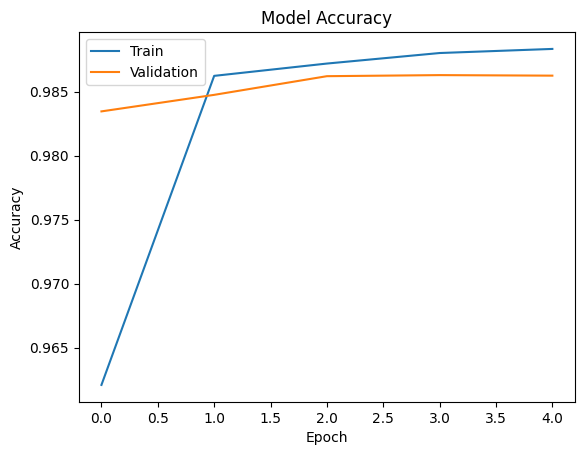

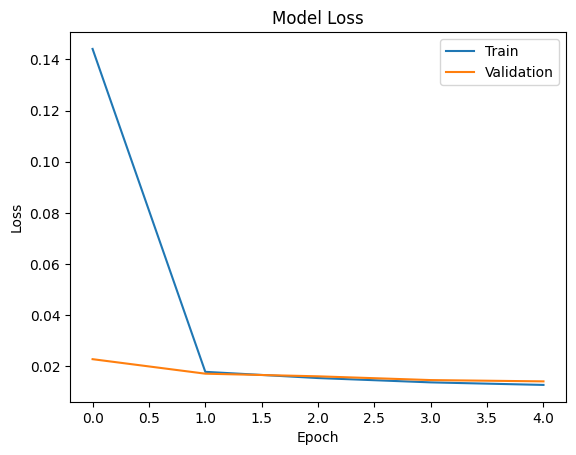

In [181]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [57]:
tag2idx

{'I-product': 2,
 'B-sportsteam': 3,
 'I-other': 4,
 'I-facility': 5,
 'I-musicartist': 6,
 'I-sportsteam': 7,
 'I-company': 8,
 'I-tvshow': 9,
 'I-person': 10,
 'B-movie': 11,
 'O': 12,
 'B-company': 13,
 'B-musicartist': 14,
 'I-movie': 15,
 'B-person': 16,
 'B-tvshow': 17,
 'B-geo-loc': 18,
 'B-product': 19,
 'I-geo-loc': 20,
 'B-other': 21,
 'B-facility': 22,
 'PAD': 0,
 'UNK': 1}

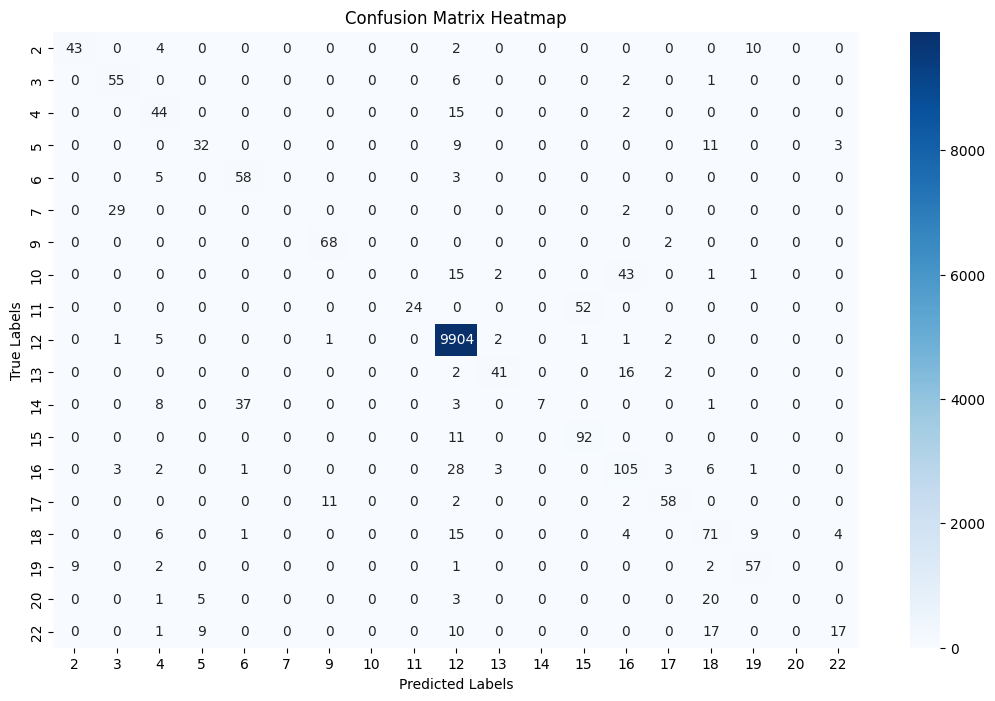

In [58]:
#Confusion matrix

conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
# Plot the heatmap
plt.figure(figsize=(13, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))
# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


**Insights**
- The class at index 12 (row/column labeled 12) is dominantly represented, with a count of 9904 correct predictions.
- Labels like:
    - 16: 105 correct, minimal confusion
    - 15: 92 correct
    - 6: 58 correct
- For some classes, predictions are spread out across nearby labels:
    - E.g., True label 10 has significant confusion with label 22.
    - True label 19 is confused with 20 and 21.

### **Testing  : Dataset evaluation and Creation**

In [59]:
test_data = read_conll("wnut 16test.txt.conll")

In [60]:
test_data[0]

[('New', 'B-other'),
 ('Orleans', 'I-other'),
 ('Mother', 'I-other'),
 ("'s", 'I-other'),
 ('Day', 'I-other'),
 ('Parade', 'I-other'),
 ('shooting', 'O'),
 ('.', 'O'),
 ('One', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('people', 'O'),
 ('hurt', 'O'),
 ('was', 'O'),
 ('a', 'O'),
 ('10-year-old', 'O'),
 ('girl', 'O'),
 ('.', 'O'),
 ('WHAT', 'O'),
 ('THE', 'O'),
 ('HELL', 'O'),
 ('IS', 'O'),
 ('WRONG', 'O'),
 ('WITH', 'O'),
 ('PEOPLE', 'O'),
 ('?', 'O')]

In [61]:
len(test_data)

3849

In [62]:
#convert to dataframe
test_df = pd.DataFrame([(token, tag) for value in test_data for token, tag in value], columns=['Token', 'Tag'])
test_df.head()

,Token,Tag
0,New,B-other
1,Orleans,I-other
2,Mother,I-other
3,'s,I-other
4,Day,I-other


In [63]:
test_df["Tag"].value_counts()

Tag
O                55941
B-geo-loc          882
B-company          621
B-other            584
I-other            556
I-product          500
B-person           482
I-facility         366
I-person           300
I-company          265
B-facility         253
B-product          246
I-geo-loc          219
B-musicartist      191
B-sportsteam       147
I-musicartist      140
I-movie             48
I-sportsteam        48
I-tvshow            40
B-movie             34
B-tvshow            33
Name: count, dtype: int64

In [64]:
#number of unique tags
test_df["Tag"].nunique()

21

In [65]:
#Creating X_test and y_test

X_test = [[word2idx.get(ele[0], word2idx["UNK"]) for ele in sentence] for sentence in test_data]
# pad the sequences, to have same length
X_test = pad_sequences(
            maxlen = MAX_LEN,
            sequences = X_test,
            padding = "post",
            value = word2idx["PAD"]
)


# Convert my Tag/Label to tag_index
y_test = [[tag2idx.get(ele[1], tag2idx["UNK"]) for ele in sentence] for sentence in test_data]

# Padding each label to have same length
y_test = pad_sequences(
            maxlen = MAX_LEN,
            sequences = y_test,
            padding = "post",
            value = tag2idx["PAD"]
)

In [66]:
X_test[0]

array([ 5689,     1,     1,  8138,  2020,  2032,  7481,  9476, 10382,
        6788, 10140,  2327, 10564,  5645,  6636,     1,  1195,  9476,
        1660,  1926,     1,  9928,     1,  6618,     1, 10394,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [67]:
y_test[0]

array([21,  4,  4,  4,  4,  4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [68]:
#predicting probabilities
y_test_pred_prob = model.predict(X_test)

121/121 [==============================] - 7s 57ms/step


In [69]:
y_test_pred_prob[0]

array([[-0.49662346, -0.08926046, -0.25474542, ..., -0.18181936,
         0.10384956, -0.0183765 ],
       [-0.36524734, -0.10205769,  0.05035735, ..., -0.06529163,
         0.04430005, -0.08518974],
       [-0.45759845, -0.11493862,  0.03634344, ..., -0.05574173,
         0.04887457, -0.09386937],
       ...,
       [ 0.60850763, -0.02545256,  0.00628159, ..., -0.02367358,
        -0.00660952,  0.00448946],
       [ 0.60850763, -0.02545256,  0.00628159, ..., -0.02367358,
        -0.00660952,  0.00448946],
       [ 0.60850763, -0.02545256,  0.00628159, ..., -0.02367358,
        -0.00660952,  0.00448946]], dtype=float32)

In [70]:
y_test_pred_prob.shape

(3849, 75, 23)

In [71]:
len(y_test_pred_prob[0])

75

In [72]:
#Convert probabilities to class predictions (for multi-class classification)
y_pred_val = np.argmax(y_test_pred_prob, axis=2)

In [73]:
y_pred_val[0]

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [74]:
len(y_pred_val[0])

75

In [75]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_pred_val, y_test)

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 0.919074316582092


In [76]:
# Classification report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       375
           3       0.07      0.03      0.04       132
           4       0.15      0.03      0.05       415
           5       0.00      0.00      0.00       270
           6       0.00      0.00      0.00       106
           7       0.00      0.00      0.00        39
           9       0.02      0.04      0.03        25
          10       0.00      0.00      0.00       229
          11       0.00      0.00      0.00        29
          12       0.93      0.99      0.96     45094
          13       0.25      0.01      0.01       343
          14       0.00      0.00      0.00       152
          15       0.00      0.00      0.00        41
          16       0.09      0.12      0.10       400
          17       0.00      0.00      0.00        26
          18       0.56      0.02      0.04       646
          19       0.00      0.00      0.00       194
    

In [77]:
np.unique(y_true_flat)

array([ 2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 22])

In [78]:
np.unique(y_pred_flat)

array([ 2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
      dtype=int64)

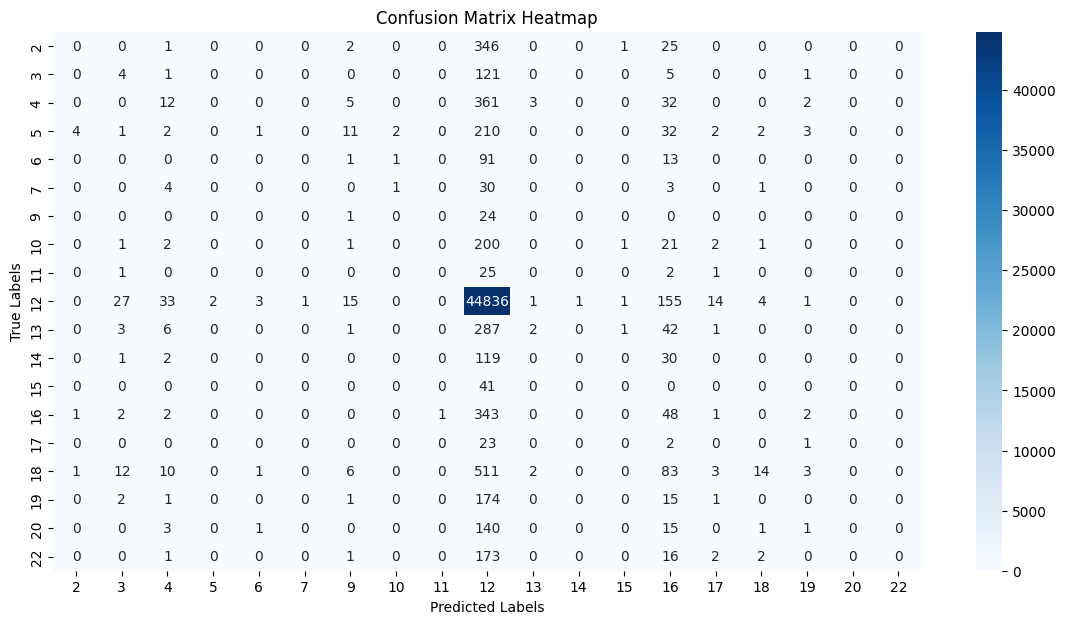

In [79]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
# Plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))
# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

**Insights**
- The cell at (12, 12) shows 44,836 correct predictions, far higher than any other.

- Several other diagonal entries show decent performance:
    - Label 6: 210 correct predictions
    - Label 8: 200
    - Label 17: 511
    - Label 19: 343
    - Label 4: 361
- Example: Label 21 and 22 show confusion with each other and label 12.

## **Word2vec : Word Embeddings with Bi-LSTM**

Initialize word representations using embeddings like word2vec to capture contextual nuances.


#### **Embeddings**

In [80]:
len(data)

2393

In [81]:
for i in range(5) :
    print(data[i])

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]
[('Made', 'O'), ('it', 'O'), ('back', 'O'), ('home', 'O'), ('to', 'O'), ('GA', 'B-geo-loc'), ('.', 'O'), ('It', 'O'), ('sucks', 'O'), ('not', 'O'), ('to', 'O'), ('be', 'O'), ('at', 'O'), ('Disney', 'B-facility'), ('world', 'I-facility'), (',', 'O'), ('but', 'O'), ('its', 'O'), ('good', 'O'), ('to', 'O'), ('be', 'O'), ('home', 'O'), ('.', 'O'), ('Time', 'O'), ('to', 'O'), ('start', 'O'), ('planning', 'O'), ('the', 'O'), ('next', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility'), ('trip', 'O'), ('.', 'O')]
[("'", 'O'), ('Breaking', 'B-movie'), ('Dawn', 'I-movie'), ("'", 'O'), ('Returns', 'O'), ('to', 'O'), ('Vancouver', 'B-geo-loc'), ('on', 'O'), ('January', 'O'), ('11th', 'O'), ('http://bit.ly/dbDMs8', 'O')]
[('@ls_n', 'O'), ('perhaps', 'O'), (',', 'O'), ('but', 'O'), ('folks', 'O'), ('may'

We have to do :
1. Preprocessing to remove tags and extract tokens
2. Train the word2vec model
3. Access word embeddings

In [82]:
#Preprocess the data to remove tags and extract tokens
sentences = [[word for word, tag in sentence] for sentence in data]


#Train Word2Vec model
embedding_size = 150
word2vec_model = Word2Vec(
                    sentences,
                    vector_size=embedding_size,
                    window=5,      # Context window size
                    min_count=1,   # Include all words
                    workers=4,     # Number of threads
                    sg=1,          # Skip-gram model
                    epochs=50      # Number of training epochs
)


In [83]:
#Access word embeddings
word_embeddings = word2vec_model.wv
print(f"Vector for 'Disney': {word_embeddings['Disney']}")

Vector for 'Disney': [-0.19565754  0.0379025  -0.05798721 -0.43139386  0.01612567  0.07583405
  0.20659405 -0.09022742 -0.07144943  0.03971274  0.47373027 -0.1063149
  0.09197829 -0.11034208  0.02919286 -0.16154766  0.08457588 -0.39511
 -0.38316485 -0.46006653 -0.15271771  0.11452392  0.34693     0.08587214
 -0.46673056 -0.27040383 -0.81301063 -0.13945514  0.01403814 -0.54830575
 -0.05635606  0.48414603 -0.0250151  -0.2413497  -0.35426027  0.282493
  0.5811573  -0.15388617  0.2147295  -0.05884006  0.05971799 -0.39104307
 -0.07654746 -0.28607187  0.12851512 -0.0640583  -0.22676156 -0.23939234
  0.11624962  0.40559003 -0.27660415  0.15829806 -0.19718081  0.21147297
  0.47331193 -0.21612026  0.13504826  0.06787694  0.11335698 -0.1254371
 -0.36593306 -0.2626308   0.45882696  0.24598198  0.18229686  0.20562327
  0.22598733 -0.19017833 -0.30808342 -0.08299855  0.28498495  0.27809057
  0.25957063 -0.15629344  0.00910866  0.08829884 -0.10943609  0.06440102
  0.07107375 -0.06234744  0.22665094 

In [84]:
word_embeddings = word2vec_model.wv
print(f"Vector for 'home': {word_embeddings['Disney']}")

Vector for 'home': [-0.19565754  0.0379025  -0.05798721 -0.43139386  0.01612567  0.07583405
  0.20659405 -0.09022742 -0.07144943  0.03971274  0.47373027 -0.1063149
  0.09197829 -0.11034208  0.02919286 -0.16154766  0.08457588 -0.39511
 -0.38316485 -0.46006653 -0.15271771  0.11452392  0.34693     0.08587214
 -0.46673056 -0.27040383 -0.81301063 -0.13945514  0.01403814 -0.54830575
 -0.05635606  0.48414603 -0.0250151  -0.2413497  -0.35426027  0.282493
  0.5811573  -0.15388617  0.2147295  -0.05884006  0.05971799 -0.39104307
 -0.07654746 -0.28607187  0.12851512 -0.0640583  -0.22676156 -0.23939234
  0.11624962  0.40559003 -0.27660415  0.15829806 -0.19718081  0.21147297
  0.47331193 -0.21612026  0.13504826  0.06787694  0.11335698 -0.1254371
 -0.36593306 -0.2626308   0.45882696  0.24598198  0.18229686  0.20562327
  0.22598733 -0.19017833 -0.30808342 -0.08299855  0.28498495  0.27809057
  0.25957063 -0.15629344  0.00910866  0.08829884 -0.10943609  0.06440102
  0.07107375 -0.06234744  0.22665094 -0

In [85]:
len(word_embeddings)

10585

### **Features and Label, Data Splitting**

In [86]:
X = [[word_embeddings[word] for word,tag in sentence] for sentence in data]

# pad the sequences, to have same length
X = pad_sequences(
        maxlen = 100,
        sequences = X,
        padding = "post",
        dtype = "float32")

In [87]:
print('Raw Sample:\n ', ' '.join([w[0] for w in data[0]]))

Raw Sample:
  @SammieLynnsMom @tg10781 they will be all done by Sunday trust me *wink*


In [88]:
X[0]

array([[ 0.03337417,  0.03831588, -0.00625378, ..., -0.0658076 ,
         0.17180328, -0.19569074],
       [ 0.06817788,  0.061602  , -0.02806851, ..., -0.0515852 ,
         0.17300291, -0.22552273],
       [ 0.3046341 , -0.00773434, -0.06674184, ...,  0.20184746,
        -0.01716485, -0.13468324],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [89]:
X.shape

(2393, 100, 150)

In [90]:
len(X)

2393

In [91]:
# Convert my Tag/Label to tag_index
y = [[tag2idx[ele[1]] for ele in sentence] for sentence in data]

# Padding each label to have same length
y = pad_sequences(
        maxlen = 100,
        sequences = y,
        padding = "post",
        value = tag2idx["PAD"]
)


# One-Hot encode
y = [to_categorical(i, num_classes=23) for i in y] # n_tags+1(PAD) 

In [92]:
print('Raw Label:\n ', ' '.join([w[1] for w in data[0]]))


Raw Label:
  O O O O O O O O O O O O


In [93]:
y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [94]:
len(y[0])

100

In [95]:
len(y)

2393

In [96]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = np.array(y_train)
y_test = np.array(y_test)


### **Modeling**

In [97]:

embedding_size = 150

def build_model(max_len=100, embedding_dim=embedding_size):
    input_layer = Input(shape=(max_len, embedding_dim), name='input_layer')

    #BiLSTM
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True, dropout=0.3))(input_layer)
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True, dropout=0.3))(lstm_output)

    #Dense layer
    dense_output = TimeDistributed(Dense(64, activation="relu"))(lstm_output)

    #CRF layer
    crf = CRF(23, name='crf')
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_output)

    model = Model(inputs=input_layer, outputs=potentials, name="Twitter_NER_V1")

    model.compile(
        optimizer=AdamW(weight_decay=0.001, learning_rate=0.001),
        loss=SigmoidFocalCrossEntropy(),
        metrics=["accuracy"]
    )

    return model


In [98]:
#model builiding
wv_ner_model = build_model()

In [99]:
# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='wv_twitter_ner_crf.weights.h5',
                monitor='val_loss',
                save_weights_only=True,
                save_best_only=True,
                verbose=1
)


# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)
callbacks = [save_model, es]


wv_ner_model.summary()

Model: "Twitter_NER_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 150)]        0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 100)         80400     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 100)         60400     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 64)          6464      
 tributed)                                                       
                                                                 
 crf (CRF)                   [(None, 100),             2070      
                              (None, 100, 23),      

In [100]:
#model fitting
history = wv_ner_model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=10,
    shuffle = True)


Epoch 1/10
68/68 [==============================] - 37s 310ms/step - loss: 0.2480 - accuracy: 0.9477 - val_loss: 0.0246 - val_accuracy: 0.9827
Epoch 2/10
68/68 [==============================] - 19s 285ms/step - loss: 0.0194 - accuracy: 0.9849 - val_loss: 0.0162 - val_accuracy: 0.9855
Epoch 3/10
68/68 [==============================] - 21s 312ms/step - loss: 0.0167 - accuracy: 0.9864 - val_loss: 0.0172 - val_accuracy: 0.9876
Epoch 4/10
68/68 [==============================] - 19s 276ms/step - loss: 0.0151 - accuracy: 0.9869 - val_loss: 0.0143 - val_accuracy: 0.9882
Epoch 5/10
68/68 [==============================] - 19s 286ms/step - loss: 0.0143 - accuracy: 0.9871 - val_loss: 0.0141 - val_accuracy: 0.9866
Epoch 6/10
68/68 [==============================] - 18s 259ms/step - loss: 0.0139 - accuracy: 0.9876 - val_loss: 0.0135 - val_accuracy: 0.9880
Epoch 7/10
68/68 [==============================] - 18s 267ms/step - loss: 0.0135 - accuracy: 0.9879 - val_loss: 0.0133 - val_accuracy: 0.9888

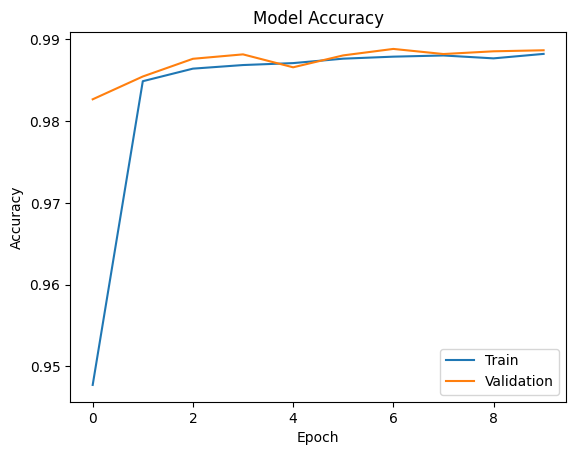

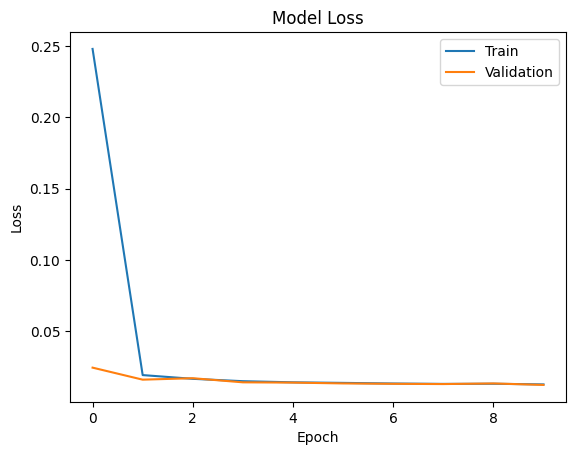

In [101]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

### **Validation Data : Evaluation**

In [102]:
# Predict probabilities
y_val_prob_pred = wv_ner_model.predict(X_test)
y_pred_val = np.argmax(y_val_prob_pred, axis=2)


8/8 [==============================] - 5s 65ms/step


In [103]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_pred_val, np.argmax(y_test, axis=2))

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9516688339835284


In [104]:
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        23
          11       0.00      0.00      0.00         4
          12       0.95      1.00      0.98      4391
          13       0.00      0.00      0.00        21
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         7
          16       0.00      0.00      0.00        48
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00        24
          19       0.00      0.00      0.00        11
    

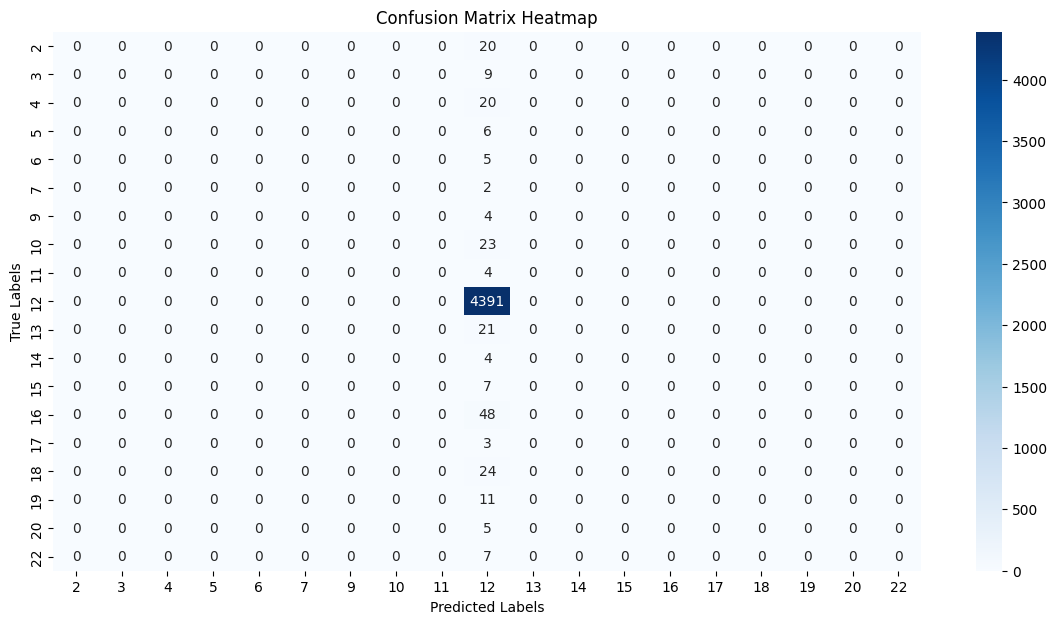

In [105]:
# # Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
# # Plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))
# # Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


### **Testing data evaluation**

In [106]:
# Define a default (zero) embedding for OOV words
unk_embedding = np.zeros(embedding_size)

# Function to get embeddings 
def get_embedding(word) :
    try :
        #access the work vector from the model
        return word_embeddings[word]
    except KeyError:
        #return a zero vector of OOV(out of vocabulary) words 
        return unk_embedding


X_test = [[get_embedding(word) for word,tag in sentence] for sentence in test_data]

# pad the sequences, to have same length
X_test = pad_sequences(
            maxlen = 100,
            sequences = X_test,
            padding = "post",
            dtype = "float32"
)


In [107]:
print('Raw Sample:\n ', ' '.join([w[0] for w in test_data[0]]))

Raw Sample:
  New Orleans Mother 's Day Parade shooting . One of the people hurt was a 10-year-old girl . WHAT THE HELL IS WRONG WITH PEOPLE ?


In [108]:
print('After processing, sample:\n', X_test[0])

After processing, sample:
 [[ 0.1727319   0.9027451  -0.5327502  ... -0.41624287  0.21264414
  -0.20837386]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [109]:
# Convert my Tag/Label to tag_index
y_test = [[tag2idx.get(ele[1], tag2idx["UNK"]) for ele in sentence] for sentence in test_data]
# Padding each label to have same length
y_test = pad_sequences(
            maxlen = 100,
            sequences = y_test,
            padding = "post",
            dtype = "float32"
)


In [110]:
# Predict probabilities
y_test_prob_pred = wv_ner_model.predict(X_test)

# Convert probabilities to class predictions (for multi-class classification)
y_test_pred = np.argmax(y_test_pred_prob, axis=2)


121/121 [==============================] - 8s 64ms/step


In [111]:
y_test_pred_prob.shape

(3849, 75, 23)

In [112]:
y_test[0]

array([21.,  4.,  4.,  4.,  4.,  4., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [113]:
y_test_pred[0]

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [114]:
y_test[10]

array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [115]:
y_test_pred[10]

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [116]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_test_pred, y_test)

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")


Accuracy: 0.919074316582092


In [117]:
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00       375
         3.0       0.07      0.03      0.04       132
         4.0       0.15      0.03      0.05       415
         5.0       0.00      0.00      0.00       270
         6.0       0.00      0.00      0.00       106
         7.0       0.00      0.00      0.00        39
         9.0       0.02      0.04      0.03        25
        10.0       0.00      0.00      0.00       229
        11.0       0.00      0.00      0.00        29
        12.0       0.93      0.99      0.96     45094
        13.0       0.25      0.01      0.01       343
        14.0       0.00      0.00      0.00       152
        15.0       0.00      0.00      0.00        41
        16.0       0.09      0.12      0.10       400
        17.0       0.00      0.00      0.00        26
        18.0       0.56      0.02      0.04       646
        19.0       0.00      0.00      0.00       194
    

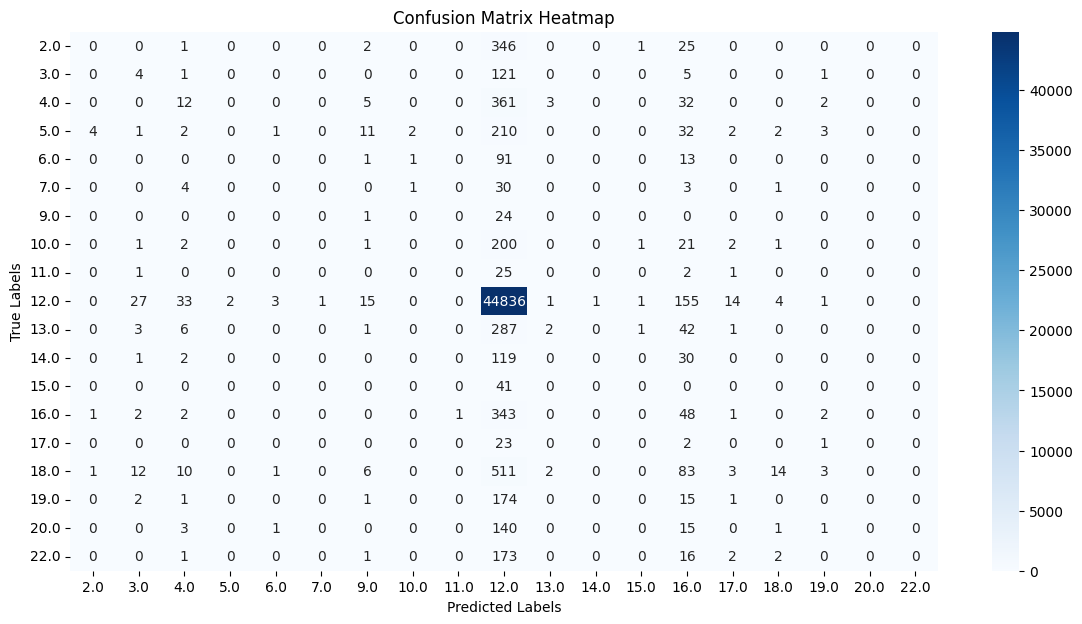

In [118]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
# Plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

**Insights**
- Cell (12, 12) contains 44,836 correct predictions, which is orders of magnitude higher than all other labels.
- Many off-diagonal cells in column 12 show that labels like:
  
        2: misclassified as 12 → 346 times
        6: → 210 times
        10: → 200 times
        13: → 287 times
        18: → 511 times
- Several true labels have low or zero correct predictions:

        Label 15: only 41 correct
        Label 17: 23 correct
        Label 20: 140 correct
        Label 22: mostly misclassified

### Hyperparameter tuning for Bi-LSTM

Experiment with hyperparameters such as LSTM units, learning rate, and dropout rates.


In [122]:
X = [[word_embeddings[word] for word,tag in sentence] for sentence in data]

# pad the sequences, to have same length
X = pad_sequences(
        maxlen = 100,
        sequences = X,
        padding = "post",
        dtype = "float32")

In [123]:
# Convert my Tag/Label to tag_index
y = [[tag2idx[ele[1]] for ele in sentence] for sentence in data]

# Padding each label to have same length
y = pad_sequences(
        maxlen = 100,
        sequences = y,
        padding = "post",
        value = tag2idx["PAD"]
)


# One-Hot encode
y = [to_categorical(i, num_classes=23) for i in y] # n_tags+1(PAD) 

In [124]:
X.shape

(2393, 100, 150)

In [125]:
len(y)

2393

In [126]:
# Data Splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [127]:
X_train[0]

array([[ 0.03301679, -0.10927553,  0.12312875, ...,  0.0938032 ,
         0.27299234,  0.16497016],
       [ 0.27168044, -0.66052824,  0.03125929, ..., -0.4661199 ,
         0.48964646, -0.30942366],
       [ 0.04411539, -0.11580908, -0.01355106, ..., -0.10396848,
         0.27436817, -0.13683335],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [128]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [129]:
X_train.shape

(2153, 100, 150)

In [130]:
y_train.shape

(2153, 100, 23)

In [131]:
X_val.shape

(240, 100, 150)

In [132]:
y_val.shape

(240, 100, 23)

In [133]:

embedding_size = 150

def build_model(lstm_units=64, dropout=0.3, learning_rate=0.001, max_len=100, embedding_dim=embedding_size):
    input_layer = Input(shape=(max_len, embedding_dim), name='input_layer')

    #BiLSTM
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True, dropout=0.3))(input_layer)
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True, dropout=0.3))(lstm_output)

    #Dense layer
    dense_output = TimeDistributed(Dense(64, activation="relu"))(lstm_output)

    #CRF layer
    crf = CRF(23, name='crf')
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_output)

    model = Model(inputs=input_layer, outputs=potentials, name="Twitter_NER_V1")

    model.compile(
        optimizer=AdamW(weight_decay=0.001, learning_rate=0.001),
        loss=SigmoidFocalCrossEntropy(),
        metrics=["accuracy"]
    )

    return model


In [134]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Store results and best model tracking
results = []
best_val_acc = 0.0
best_model_path = ""

# Define your hyperparameter grid
lstm_units_list = [64, 128]
learning_rates = [0.001, 0.0005]
dropouts = [0.3, 0.5]

# Iterate through all combinations
for unit in lstm_units_list:
    for lr in learning_rates:
        for dropout in dropouts:
            print(f"\nTraining with LSTM={unit}, LR={lr}, Dropout={dropout}")

            # Build the model
            model = build_model(lstm_units=unit, dropout=dropout, learning_rate=lr)

            # Save best model for this configuration
            model_filename = f"model_lstm{unit}_lr{lr}_drop{dropout}.h5"
            checkpoint = ModelCheckpoint(
                model_filename,
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False,
                mode='max',
                verbose=1
            )

            # Train the model
            history = model.fit(
                X_train, y_train, validation_data=(X_val, y_val), 
                epochs=5, batch_size=32,
                callbacks=[checkpoint],
                verbose=2
            )

            # Get best val_accuracy for this run
            val_acc = max(history.history['val_accuracy'])
            val_loss = min(history.history['val_loss'])

            # Track result
            results.append({
                'lstm_units': unit,
                'learning_rate': lr,
                'dropout': dropout,
                'val_accuracy': val_acc,
                'val_loss': val_loss,
                'model_path': model_filename
            })

            # Update best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_path = model_filename



Training with LSTM=64, LR=0.001, Dropout=0.3
Epoch 1/5

Epoch 1: val_accuracy improved from -inf to 0.98296, saving model to model_lstm64_lr0.001_drop0.3.h5
68/68 - 34s - loss: 0.2140 - accuracy: 0.9564 - val_loss: 0.0256 - val_accuracy: 0.9830 - 34s/epoch - 505ms/step
Epoch 2/5

Epoch 2: val_accuracy did not improve from 0.98296
68/68 - 18s - loss: 0.0197 - accuracy: 0.9855 - val_loss: 0.0292 - val_accuracy: 0.9726 - 18s/epoch - 263ms/step
Epoch 3/5

Epoch 3: val_accuracy improved from 0.98296 to 0.98571, saving model to model_lstm64_lr0.001_drop0.3.h5
68/68 - 17s - loss: 0.0186 - accuracy: 0.9855 - val_loss: 0.0169 - val_accuracy: 0.9857 - 17s/epoch - 257ms/step
Epoch 4/5

Epoch 4: val_accuracy did not improve from 0.98571
68/68 - 16s - loss: 0.0156 - accuracy: 0.9873 - val_loss: 0.0162 - val_accuracy: 0.9856 - 16s/epoch - 230ms/step
Epoch 5/5

Epoch 5: val_accuracy improved from 0.98571 to 0.98629, saving model to model_lstm64_lr0.001_drop0.3.h5
68/68 - 16s - loss: 0.0145 - accurac

## **Using Transformers**

We use 'bert-based-uncased' model from the transformers library

In [135]:
data[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [136]:
import torch
from transformers import BertTokenizerFast, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import Dataset, ClassLabel, Features, Sequence, Value
import evaluate
import numpy as np

In [137]:
# Separate words and labels for the Hugging Face Dataset format

all_words = [[word for word, label in sentence] for sentence in data]
all_labels = [[label for word, label in sentence] for sentence in data]

In [138]:
all_words[0]

['@SammieLynnsMom',
 '@tg10781',
 'they',
 'will',
 'be',
 'all',
 'done',
 'by',
 'Sunday',
 'trust',
 'me',
 '*wink*']

In [139]:
all_labels[0]

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [140]:
# Create a mapping from label strings to integers
unique_labels = sorted(list(set(label for sentence_labels in all_labels for label in sentence_labels)))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert string labels to integer IDs
all_label_ids = [[label_to_id[label] for label in sentence_labels] for sentence_labels in all_labels]

In [141]:
all_label_ids[0]

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

In [142]:
# Create Hugging Face Dataset
features = Features({
    'words': Sequence(Value('string')),
    'labels': Sequence(ClassLabel(names=unique_labels))
})

dataset_dict = {
    'train': Dataset.from_dict({'words': all_words, 'labels': all_label_ids}, features=features)
}

# Example of accessing the dataset
print(dataset_dict['train'][0])

{'words': ['@SammieLynnsMom', '@tg10781', 'they', 'will', 'be', 'all', 'done', 'by', 'Sunday', 'trust', 'me', '*wink*'], 'labels': [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]}


### **Load BertTokenizer and Define Tokenization Function**

In [168]:
model_checkpoint = "bert-base-uncased"  # Or "bert-base-cased" if your data is cased
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)

In [169]:
#defining the tokenizing function and alligning with the corresponding label
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["words"],
        is_split_into_words=True, # Important: tells tokenizer inputs are pre-tokenized
        padding="max_length",     # Pad to max_length of the batch or model's max_length
        truncation=True           # Truncate if sequence is too long
    )

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id of None. We set their label to -100 to be ignored.
            if word_idx is None:
                label_ids.append(-100)
            # Only label the first token of a given word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For subsequent tokens of the same word, set label to -100
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the tokenization and alignment function to your dataset
tokenized_dataset = dataset_dict['train'].map(
    tokenize_and_align_labels,
    batched=True
)


Map:   0%|          | 0/2393 [00:00<?, ? examples/s]

In [170]:
tokenized_dataset

Dataset({
    features: ['words', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2393
})

In [171]:
# Rename the 'labels' column to 'labels' as expected by the model
tokenized_dataset = tokenized_dataset.remove_columns(['words'])

#converting to PyTorch tensors
tokenized_dataset.set_format("torch")


**Train test split**

In [172]:
from datasets import DatasetDict
ds = tokenized_dataset.train_test_split(test_size=0.2)
train_ds = ds['train']
test_ds = ds['test']

In [173]:
print("Shape of Training data", train_ds.shape)
print("Shape of Testing data", test_ds.shape)

Shape of Training data (1914, 4)
Shape of Testing data (479, 4)


**Load the Model**

In [174]:
num_labels = len(unique_labels)
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Define the Arguements**

In [175]:
training_args = TrainingArguments(
    output_dir="./results",               # directory to save checkpoints
    evaluation_strategy="epoch",          # evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",                 # directory for logs
    logging_steps=10,
    save_strategy="epoch",                # save model at the end of each epoch
    load_best_model_at_end=True,          # load the best model found during training
    metric_for_best_model="f1",           # metric to use for early stopping/best model
    report_to="none"                      # to avoid weights and bias overhead
)

**Define metrics**

In [176]:
# Load the seqeval metric
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens and subsequent subword tokens)
    true_predictions = [
        [id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id_to_label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [177]:
# Data collator for token classification: dynamically pads to the maximum length in a batch
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds, # Use tokenized_train_dataset if you split
    eval_dataset=test_ds,   # Use tokenized_eval_dataset if you split
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

**Save model**

In [178]:
model.save_pretrained('./ner_model')
tokenizer.save_pretrained('./ner_model')

('./ner_model\\tokenizer_config.json',
 './ner_model\\special_tokens_map.json',
 './ner_model\\vocab.txt',
 './ner_model\\added_tokens.json',
 './ner_model\\tokenizer.json')

In [179]:
def predict(text):
    tokens = text.split()
    inputs = tokenizer(tokens, return_tensors="pt", is_split_into_words=True)
    outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)
    labels = [id_to_label[p.item()] for p in predictions[0]]
    return list(zip(tokens, labels))

predict("i love disney world and ga")


[('i', 'B-facility'),
 ('love', 'I-other'),
 ('disney', 'B-company'),
 ('world', 'B-sportsteam'),
 ('and', 'B-musicartist'),
 ('ga', 'B-movie')]

## **Insights**
1. Using Bi-LSTM with CRF:
    - Achieved high accuracy on the validation dataset.
    - Results showed close to 99% accuracy with good recall and precision values for each entity.
2. Comparison with Word2Vec Embeddings:
    - Directly using pre-trained Word2Vec embeddings in a neural network resulted in lower accuracy.
    - Incorporating a custom embedding layer and training on top of it yielded better performance.

## *Question and Answers*

1. **Defining the problem statements, and where can this and modications of this be used?**
 - We’ve finalized NER for over 25 entities that help social networking giants like Twitter, Instagram, Reddit, Inc., Pinterest, LinkedIn (the usual suspects) gather insights and boost user engagement. Because, obviously, understanding what people are posting is important.

2. **Explain the data format (CoNLL BIO format).**
 - The CoNLL BIO format is a common structure for annotating text data for NER tasks. Each token is assigned a label indicating whether it begins (B), is inside (I), or is outside (O) of a named entity. For example:

        Harry B-PER
        
        Potter I-PER
        
        was O
        
        a O
        
        student O
        
        Living O
        
        in O
        
        London B-geo-loc

3.  **What other NER data annotation formats are available and how are they different?**
- IOB: Similar to BIO but lacks the distinction between beginning (B) and inside (I) when there is no ambiguity.
- BIOES: Extends BIO by adding labels for single-token entities (S) and the end of entities (E).
- BILOU: Similar to BIOES, but uses "L" for the last token of an entity and "U" for unit-length entities.

4. **Why do we need tokenization of the data in our case?**
- Tokenization breaks text into manageable units (tokens) for processing. For NER, it ensures proper alignment of tokens with entity annotations, facilitating accurate tagging and model training.

5. **What other models can you use for this task?**
- Alternatives include spaCy, Flair, T5, GPT-4, and custom transformer-based models.

6.  **Did early stopping have any e ect on the training and results?**
- Early stopping prevents over tting, especially when training on small datasets. It ensures the model generalizes better to unseen data

7. **How does the BERT model expect a pair of sentences to be processed?**
- BERT concatenates sentences with a [SEP] token and prepends them with a  [CLS] token. The input is tokenized and converted into embeddings.

8. **Why choose attention-based models over recurrent-based ones?**
- Attention mechanisms process all tokens simultaneously, enabling better handling of long-range dependencies and faster training. RNNs process tokens sequentially, which can be slower and less effective for long texts.

9. **Differentiate BERT and Simple Transformers.**
- BERT: A transformer-based model pre-trained on masked language modeling and next-sentence prediction.
- Simple Transformers: A Python library that simplifes the training and fine-tuning of transformer models, including BERT, for various NLP tasks